## Parcels

In [1]:
import math
from datetime import timedelta
from operator import attrgetter

import matplotlib.pyplot as plt
import numpy as np
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

import netCDF4 as nc
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho']
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho']
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
h = dataset.variables['h']
h = np.transpose(h, (1, 0))
previous_file_idx = -1

Loaded time steps: [      0.   86400.  172800.  259200.  345600.  432000.  518400.  604800.
  691200.  777600.  864000.  950400. 1036800. 1123200. 1209600. 1296000.
 1382400. 1468800. 1555200. 1641600. 1728000. 1814400. 1900800. 1987200.
 2073600. 2160000. 2246400. 2332800. 2419200. 2505600.]
Data shape: (2, 30, 317, 272)


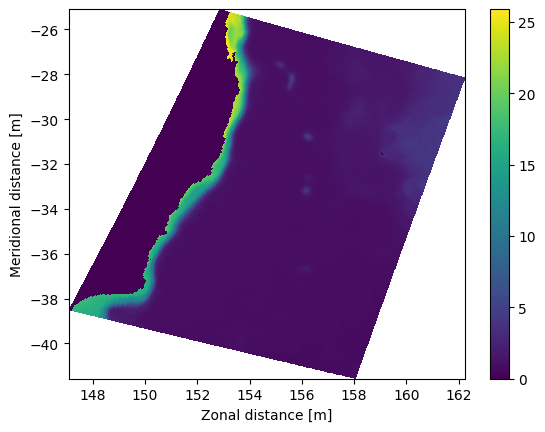

In [49]:
fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

filenames = {
    "U": fname,
    "V": fname,
    'temp': fname
}
variables = {
    "U": "u_eastward",
    "V": "v_northward",
    'temp': 'temp'
}
dimensions = {"time": "ocean_time", "lat": "lat_rho", "lon": "lon_rho", 'depth': 's_rho'}

# Ensure no restrictions on time or depth indices
indices = {}  # This loads all available data points in all dimensions

# Create the FieldSet
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, indices, allow_time_extrapolation=True, time_periodic=False)

class SampleParticle(parcels.JITParticle):
    temp = parcels.Variable('temp', dtype=np.float32)

fieldset.computeTimeChunk()

# Verify the time steps loaded
print("Loaded time steps:", fieldset.temp.grid.time_full)
print("Data shape:", fieldset.temp.data.shape)

plt.pcolormesh(fieldset.temp.grid.lon, fieldset.temp.grid.lat, fieldset.temp.data[0, 0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()
plt.show()


## Solution 1: Manually Loop Through Time Steps

Final Data Shape: (30, 30, 317, 272)


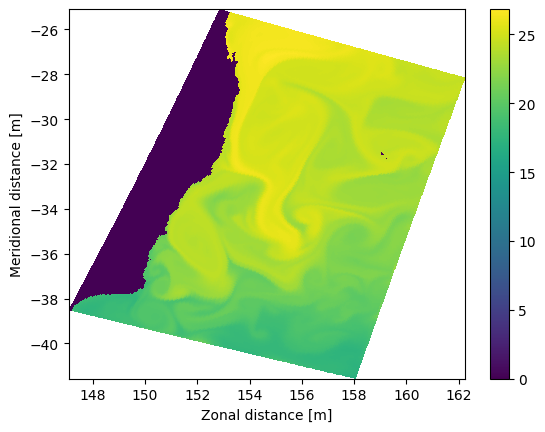

In [2]:
import parcels
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

# File and variable setup
fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

filenames = {
    "U": fname,
    "V": fname,
    'temp': fname
}
variables = {
    "U": "u_eastward",
    "V": "v_northward",
    'temp': 'temp'
}
dimensions = {"time": "ocean_time", "lat": "lat_rho", "lon": "lon_rho", 'depth': 's_rho'}

indices = {}  # Load all available data points in all dimensions

# Create the FieldSet
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, indices, allow_time_extrapolation=True, time_periodic=False)

# Class definition for particles (not necessary for this example but included for completeness)
class SampleParticle(parcels.JITParticle):
    temp = parcels.Variable('temp', dtype=np.float32)

# Manually loop through all time steps to load data
all_temp_data = []

for t in range(len(fieldset.temp.grid.time_full)):
    fieldset.computeTimeChunk(time=fieldset.temp.grid.time_full[t])
    all_temp_data.append(fieldset.temp.data[0])  # Append each time step data

all_temp_data = np.array(all_temp_data)  # Convert list to numpy array

print("Final Data Shape:", all_temp_data.shape)  # This should give you (30, 30, 317, 272)

# Plot the first time step and depth level for visualization
plt.pcolormesh(fieldset.temp.grid.lon, fieldset.temp.grid.lat, all_temp_data[20, 29, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()
plt.show()


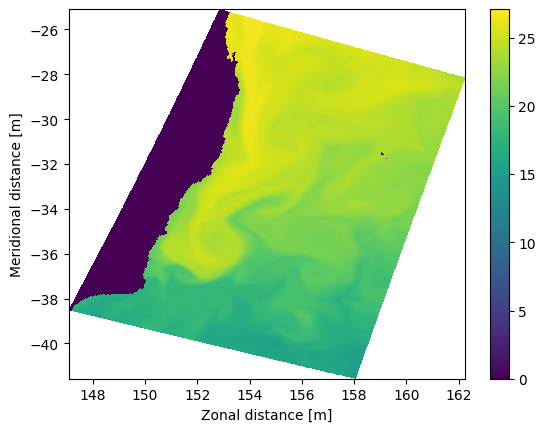

In [48]:
# fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

# filenames = {
#     "U": fname,
#     "V": fname,
#     'temp': fname
# }
# variables = {
#     "U": "u_eastward",
#     "V": "v_northward",
#     'temp': 'temp'
# }
# dimensions = {"time": "ocean_time", "lat": "lat_rho", "lon": "lon_rho", 'depth': 's_rho'}

# indices = {'time': range(30)}  # No depth index specified to include all depths

# fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, indices, allow_time_extrapolation=True)

# class SampleParticle(parcels.JITParticle):
#     temp = parcels.Variable('temp', dtype=np.float32)

# fieldset.computeTimeChunk()

# plt.pcolormesh(fieldset.temp.grid.lon, fieldset.temp.grid.lat, fieldset.temp.data[0, 27, :, :])
# plt.xlabel("Zonal distance [m]")
# plt.ylabel("Meridional distance [m]")
# plt.colorbar()
# plt.show()


In [4]:
fieldset.temp.data.shape

(2, 30, 317, 272)

In [5]:
# lon = daydic['Day1'].Lon
# lat = daydic['Day1'].Lat

i = list(range(90,180))
j = list(range(70,130))

i = i[::10]
j = j[::10]

i, j = np.meshgrid(i, j)

lon = lon_rho[i,j]
lat = lat_rho[i,j]

In [6]:
pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=SampleParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=lon,  # a vector of release longitudes
    lat=lat,  # a vector of release latitudes
)

In [8]:
fieldset.temp.data.shape

(2, 30, 317, 272)

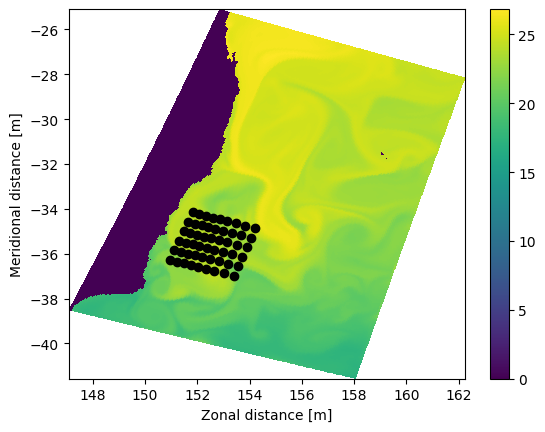

In [9]:
plt.pcolormesh(fieldset.temp.grid.lon, fieldset.temp.grid.lat, fieldset.temp.data[0, 29, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

In [ ]:
import parcels
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import timedelta

# Assuming lon, lat, and SampleParticle are defined and fieldset is already set up

pset = parcels.ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=SampleParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=lon,  # a vector of release longitudes
    lat=lat,  # a vector of release latitudes
)

def SampleP(particle, fieldset, time):
    """Custom function that samples fieldset.temp at particle location"""
    particle.temp = fieldset.temp[time, particle.depth, particle.lat, particle.lon]

output_file = pset.ParticleFile(name="PeninsulaPressure.zarr", outputdt=timedelta(hours=1))

pset.execute(
    [parcels.AdvectionRK4, SampleP],  # list of kernels to be executed
    runtime=timedelta(days=20),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

# Loading the resulting data
ds = xr.open_zarr("PeninsulaPressure.zarr")

# Plotting the temperature field
plt.contourf(fieldset.temp.grid.lon, fieldset.temp.grid.lat, fieldset.temp.data[0, 0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

# Plotting particle positions colored by temperature
plt.scatter(ds.lon, ds.lat, c=ds.temp, s=30, cmap="viridis", edgecolors="k")
plt.show()


In [10]:
def SampleP(particle, fieldset, time):
    """Custom function that samples fieldset.P at particle location"""
    particle.temp = fieldset.temp[time, particle.depth, particle.lat, particle.lon]

In [9]:
output_file = pset.ParticleFile(
    name="PeninsulaPressure.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    [parcels.AdvectionRK4, SampleP],  # list of kernels to be executed
    runtime=timedelta(days=20),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

INFO: Output files are stored in PeninsulaPressure.zarr.
100%|██████████| 1728000.0/1728000.0 [00:34<00:00, 50445.37it/s]


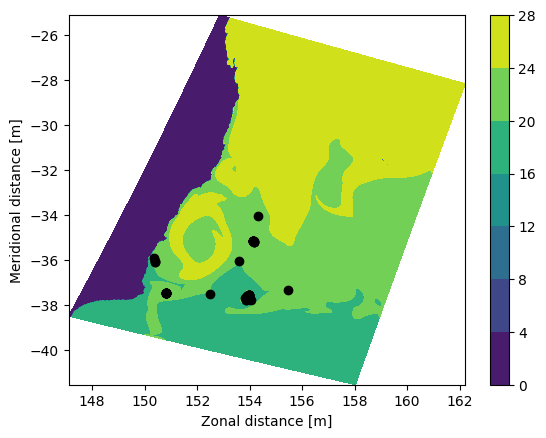

In [10]:
plt.contourf(fieldset.temp.grid.lon, fieldset.temp.grid.lat, fieldset.temp.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

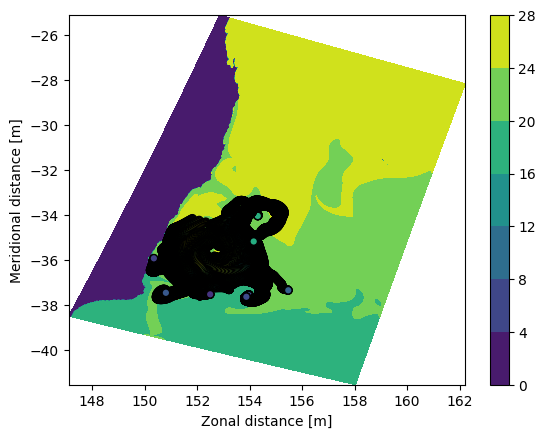

In [11]:
ds = xr.open_zarr("PeninsulaPressure.zarr")

plt.contourf(fieldset.temp.grid.lon, fieldset.temp.grid.lat, fieldset.temp.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.scatter(ds.lon, ds.lat, c=ds.temp, s=30, cmap="viridis", edgecolors="k")
plt.show()

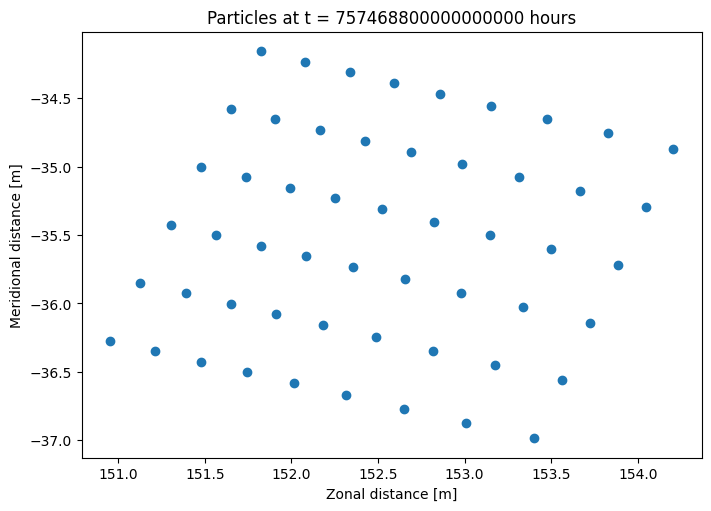

In [12]:
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
# ax.set_xlim(0, 4e5)
# ax.set_ylim(0, 7e5)

# show only every fifth output (for speed in creating the animation)
timerange = np.unique(ds["time"].values)[::5]

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id])

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [13]:
HTML(anim.to_jshtml())